# Augurpy

This is a short tutorial demonstrating augurpy, the python implementation of [Augur R package](https://github.com/neurorestore/Augur) based on Skinnider, M.A., Squair, J.W., Kathe, C. et al. [Cell type prioritization in single-cell data](https://doi.org/10.1038/s41587-020-0605-1). Nat Biotechnol 39, 30–34 (2021). 


Augurpy aims to rank or prioritize cell types according to the their response to experimental perturbations given high dimensional single-cell sequencing data. The basic idea is that in the space of molecular measurements cells reacting heavily to induced perturbations are more easily seperated into perturbed and unperturbed than cell types with little or no response. This seperability is quantified by measuring how well experimental labels (eg. treatment and control) can be predicted within each cell type. Augurpy trains a machine learning model predicting experimental labels for each cell type in multiple cross validation runs and then prioritizes cell type response according to metric scores measuring the accuracy of the model. For categorical data the area under the curve is the default metric and for numerical data the concordance correlation coefficient is used as a proxy for how accurate the model is which in turn approximates perturbation response. 

The following tutorial runs through a simple analysis with augurpy using a simulated dataset. This dataset consists of 600 cells, distributed evenly between three populations (cell types A, B, and C). Each of these cell types has approximately half of its cells in one of two conditions, treatment and control. The cell types also have different numbers of genes differentially expressed in response to the treatment. Cell type A has approximately 5% of genes DE in response to the treatment, while cell type B has 25% of its genes DE and cell type C has 50% of genes DE. 

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import scanpy as sc
import augurpy.read_load, augurpy.estimator, augurpy.evaluate 
import augurpy.plotting.lollipop
import augurpy.plotting.scatterplot
import augurpy.plotting.differential_prioritization

First we import the data that we want to work with. This can either be an anndata object, a dataframe containing cell type labels as well as conditions for each cell or data contained in a dataframe with corresponding meta data containing cell type labels and conditions. Here we use scanpy to read the simulated sample anndata set contained in augurpy. Then we load this data into an anndata object adding dummie variables of labels, highly variable genes and standardizing cell type and label observation columns. 

In [3]:
# import sample simulation data
adata = sc.read_h5ad("../tests/sc_sim.h5ad")

loaded_data = augurpy.read_load.load(adata)

In [4]:
loaded_data

AnnData object with n_obs × n_vars = 600 × 15697
    obs: 'label', 'cell_type', 'y_'
    var: 'name', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg'

Next we choose the estimator used to measure how predictable the perturbation labels for each cell type in the dataset are. Choose `random_forest_classifier` or `logistic_regression_classifier` for categorical data and `random_forest_regressor` for numerical data. 

In [5]:
random_forest = augurpy.estimator.create_estimator("random_forest_classifier",
                                                   augurpy.estimator.Params(random_state=42))

Then we run augurpy with the function `predict` and look at the results. 

In [6]:
result_adata, results = augurpy.evaluate.predict(loaded_data, random_forest, random_state=42)

print(results['summary_metrics'])

Output()

                  CellTypeA  CellTypeB  CellTypeC
mean_augur_score   0.678503   0.908673    0.98754
mean_auc           0.678503   0.908673    0.98754
mean_accuracy      0.598791   0.794982    0.91696
mean_precision     0.598791   0.794982    0.91696
mean_f1            0.598791   0.794982    0.91696
mean_recall        0.598791   0.794982    0.91696


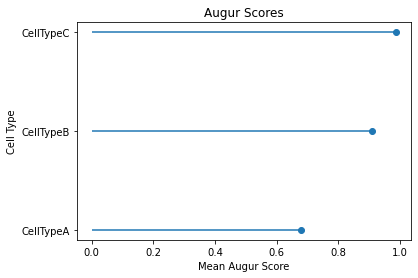

In [7]:
augurpy.plotting.lollipop.plot_lollipop(results)

The corresponding `mean_augur_score` is also saved in `result_adata.obs`. The feature importances can be found in `results['feature_importances']` and used for further analysis. 

### Feature Importances

In the case of a random forest estimator the feature importances built into sci-kit learn were used as feature importances. For the logistic regression the agresti method was used (as in the R library Augur). This means the mean was subtracted from the coefficient values and then divided by the standard deviation. (See [blog post](https://think-lab.github.io/d/205/))

In [8]:
results['feature_importances']

,genes,feature_importances,subsample_idx,fold,cell_type
0,Gene7100,0.000000,0,0,CellTypeA
1,Gene14122,0.000000,0,0,CellTypeA
2,Gene7758,0.000000,0,0,CellTypeA
3,Gene719,0.001818,0,0,CellTypeA
4,Gene4787,0.000000,0,0,CellTypeA
...,...,...,...,...,...
773545,Gene11797,0.000000,49,2,CellTypeC
773546,Gene7473,0.000000,49,2,CellTypeC
773547,Gene6086,0.000000,49,2,CellTypeC
773548,Gene4094,0.000000,49,2,CellTypeC


### Differential Prioritization

Augurpy is also able to perform differential prioritization and executes a permutation test ot identify cell types with statistically significant differences in AUC between two different rounds of cell type prioritization (eg. response to drugs A and B, compared to untreated control). 

In the following data, `withdraw_15d_Cocaine` and `withdraw_48h_Cocaine` will be compared with repsect to the difference to `Maintenance_Cocaine`.

In [9]:
# Load data and classifier
bhattacher_adata = sc.read_h5ad("../data/bhattacher.h5ad")
random_forest = augurpy.estimator.create_estimator("random_forest_classifier")

For this we first run Augur on `Maintenance_Cocaine` and `withdraw_15d_Cocaine` in `augur_mode`=`default`  and `augur_mode`=`permute` mode. 

In [10]:
# default
bhattacher_A = augurpy.read_load.load(bhattacher_adata, 
                                     condition_label='Maintenance_Cocaine', 
                                     treatment_label='withdraw_15d_Cocaine')

bhattacher_adata_A, bhattacher_results_A = augurpy.evaluate.predict(bhattacher_A, 
                                                                  n_threads=1, 
                                                                  classifier=random_forest, 
                                                                  random_state=None)

print(bhattacher_results_A['summary_metrics'].loc['mean_augur_score'].sort_values(ascending=False))

Data not normalized. Normalizing now using scanpy log1p normalize.

Filtering samples with Maintenance_Cocaine and withdraw_15d_Cocaine labels.

Output()

Astro         0.949853
OPC           0.903503
Microglia     0.890986
Oligo         0.889195
Endo          0.816757
Excitatory    0.740726
NF Oligo      0.739308
Inhibitory    0.736599
Name: mean_augur_score, dtype: float64


In [11]:
# permute
bhattacher_adata_A_permute, bhattacher_results_A_permute = augurpy.evaluate.predict(bhattacher_A,
                                                                                  n_threads=4,
                                                                                  augur_mode='permute',
                                                                                  classifier=random_forest,
                                                                                    n_subsamples = 100,
                                                                                  random_state=None)

Output()

Now lets do the same looking at `Maintenance_Cocaine` and `withdraw_48h_Cocaine`.

In [12]:
# default
bhattacher_B = augurpy.read_load.load(bhattacher_adata, 
                                     condition_label='Maintenance_Cocaine', 
                                     treatment_label='withdraw_48h_Cocaine')

bhattacher_adata_B, bhattacher_results_B = augurpy.evaluate.predict(bhattacher_B, 
                                                                    n_threads=1,
                                                                    classifier=random_forest,
                                                                    random_state=None)

print(bhattacher_results_B['summary_metrics'].loc['mean_augur_score'].sort_values(ascending=False))

Filtering samples with Maintenance_Cocaine and withdraw_48h_Cocaine labels.

Output()

Microglia     0.738288
Astro         0.719229
Inhibitory    0.692460
Oligo         0.659943
OPC           0.645431
Endo          0.625839
NF Oligo      0.573946
Excitatory    0.556848
Name: mean_augur_score, dtype: float64


In [13]:
# permute
bhattacher_adata_B_permute, bhattacher_results_B_permute = augurpy.evaluate.predict(bhattacher_B,
                                                                                  n_threads=4,
                                                                                  augur_mode='permute',
                                                                                  classifier=random_forest,
                                                                                    n_subsamples = 100,
                                                                                  random_state=None)

Output()

[bold red]Skipping NF Oligo cell type - 79 samples is less than min_cells 100.

Lets also take a look at the augur scores of the two versions in a scatterplot.

The diagonal line is the identity function. If the values were the same they would be on the line. 

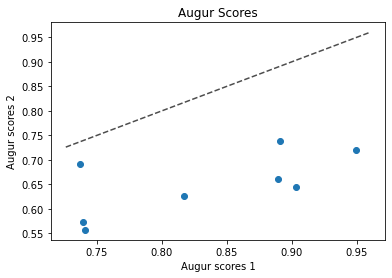

In [14]:
augurpy.plotting.scatterplot.plot_scatterplot(bhattacher_results_A, bhattacher_results_B)

To figure out which cell type was most affected in comparing `withdraw_48h_Cocaine` and `withdraw_15d_Cocaine` we can run differential prioritization.

In [15]:
import augurpy.differential_prioritization

In [16]:
pvals = augurpy.differential_prioritization.predict_differential_prioritization(augur_results1=bhattacher_results_A,
                                                                               augur_results2=bhattacher_results_B,
                                                                               permuted_results1=bhattacher_results_A_permute,
                                                                               permuted_results2=bhattacher_results_B_permute)

In [17]:
pvals

,cell_type,mean_augur_score1,mean_augur_score2,delta_augur,b,m,z,pval,padj
0,Endo,0.816757,0.625839,-0.190918,674,1000,2.975255,0.653347,0.913087
1,Astro,0.949853,0.719229,-0.230624,456,1000,-2.687116,0.913087,0.913087
2,Oligo,0.889195,0.659943,-0.229252,419,1000,-2.629701,0.839161,0.913087
3,Excitatory,0.740726,0.556848,-0.183878,862,1000,-10.931720,0.277722,0.913087
4,OPC,0.903503,0.645431,-0.258073,646,1000,-8.156192,0.709291,0.913087
5,Inhibitory,0.736599,0.692460,-0.044138,748,1000,16.298981,0.505495,0.913087
6,Microglia,0.890986,0.738288,-0.152698,96,1000,8.390574,0.193806,0.913087


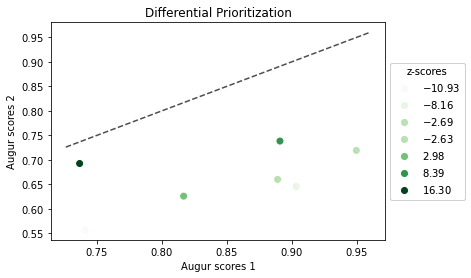

In [18]:
augurpy.plotting.differential_prioritization.plot_differential_prioritization(pvals)

In this case the cell type Microglia has the lowest p-value, meaning that in comparing the impact of `withdraw_48h_Cocaine` and `withdraw_15d_Cocaine`, this cell type was most impacted. 